In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo
import sspspace

In [197]:
# useful helper functions

import scipy.special
def sparsity_to_x_intercept(d, p):
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))


# ReLU neuron model
def relu(x, bias):
    return np.maximum(0, x-bias)


## One-dimensional SSPs

Let's start in one-dimensional space and generate a bunch of neurons with random SSPs for encoders.

First let's just generate the tuning curves

In [227]:
D = 512    # dimensionality of the SSP space
p = 0.1    # desired sparsity expressed as probability that a neuron is active
N = 5000   # number of random neurons to generate
length_scale = 2

encoder = sspspace.RandomSSPSpace(domain_dim=1, ssp_dim=D, length_scale=length_scale)

domain = np.linspace(-10,10,500)  # points to use to plot the neuron response
ssp_domain = encoder.encode(domain[:,None])

# compute the bias that gives the desired sparsity
bias = sparsity_to_x_intercept(D, p=p)

# generate random SSPs for the neurons
kc_ssp = nengo.dists.UniformHypersphere(surface=True).sample(n=N, d=D)

# compute the activity
activity = relu(np.array(ssp_domain).dot(kc_ssp.T), bias=bias)


Now we can check that the sparsity is what we asked for

In [228]:

print(f'sparsity: {np.mean(activity>0)}   (desired sparsity was {p})')


sparsity: 0.0996848   (desired sparsity was 0.1)


That worked!  Now let's see what those tuning curves look like.  Let's plot them for the first 16 neurons

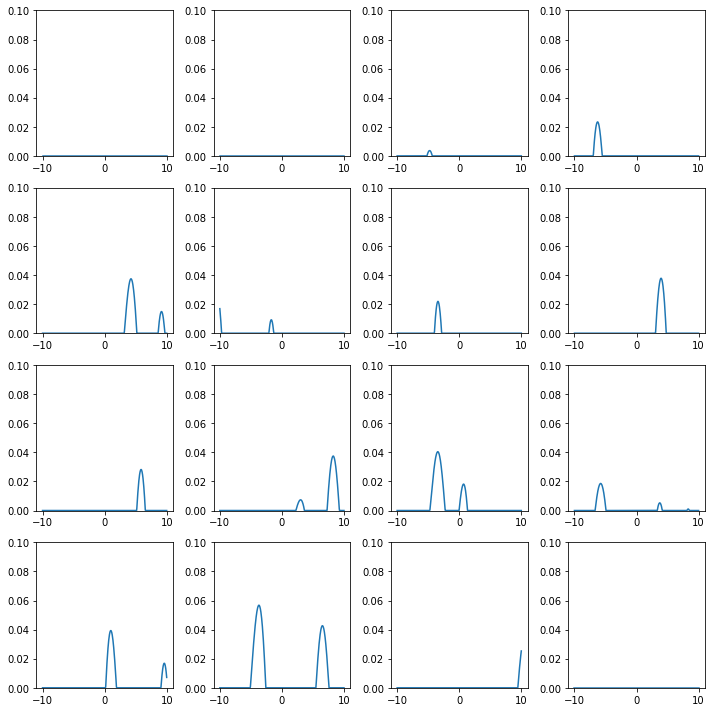

In [229]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.plot(domain, activity[:,i])
    plt.ylim(0, 0.1)
plt.tight_layout()
plt.show()

Now let's compute the auto-correlation.  I do this here by computing the auto-correlation for each neuron, and then averaging those all together so we get the mean autocorrelation.  The vertical lines are at plus and minus one length-scale, so that's when we should expect the autocorrelation to drop off.

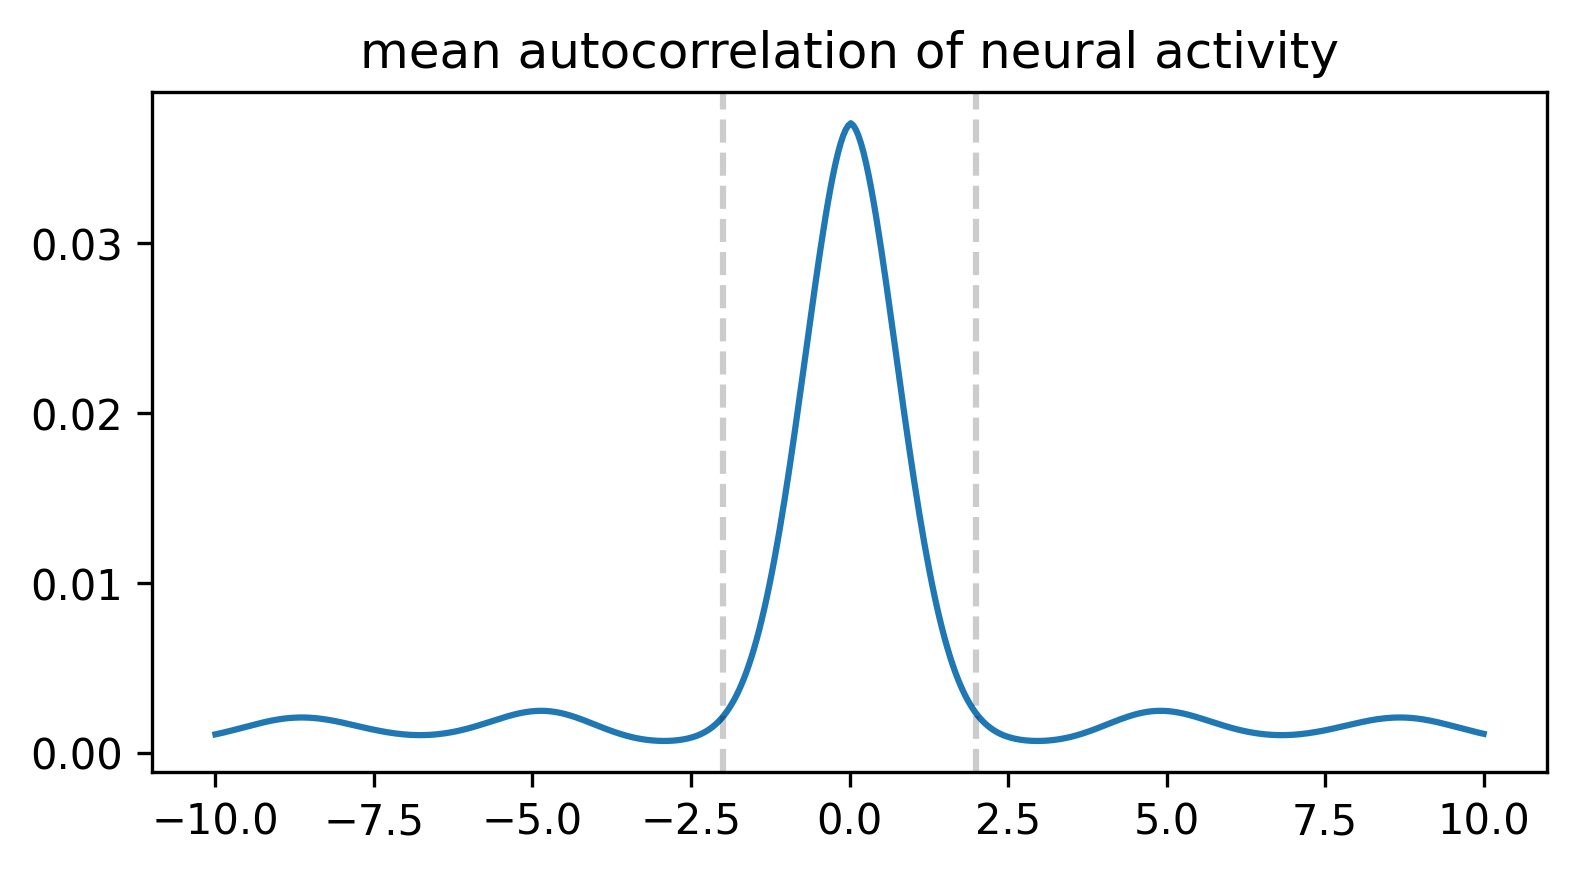

In [230]:
r = []
for a in activity.T:
    r.append(scipy.signal.correlate(a, a, 'same'))
plt.figure(figsize=(6,3), dpi=300)
plt.title('mean autocorrelation of neural activity')
plt.plot(domain, np.mean(r, axis=0))
plt.axvline(-length_scale, ls='--', c='k', alpha=0.2)
plt.axvline(length_scale, ls='--', c='k', alpha=0.2)
plt.show()


That seems to work nicely!  Although I'm not quite sure what threshold I would put for a default background, so it's not quite clear to me from the above graph that the length scale indicates when the autocorrelation drops to that level.  However, there's another plot we can make where there is a good threshold.

This other plot is to do the same thing, but just consider whether the neuron is on or not.  So we're not considering how active the neuron is.  For this, we know that the background expected correlation is $p \times p \times S$ where $S$ is the length of the vector being auto-correlated.

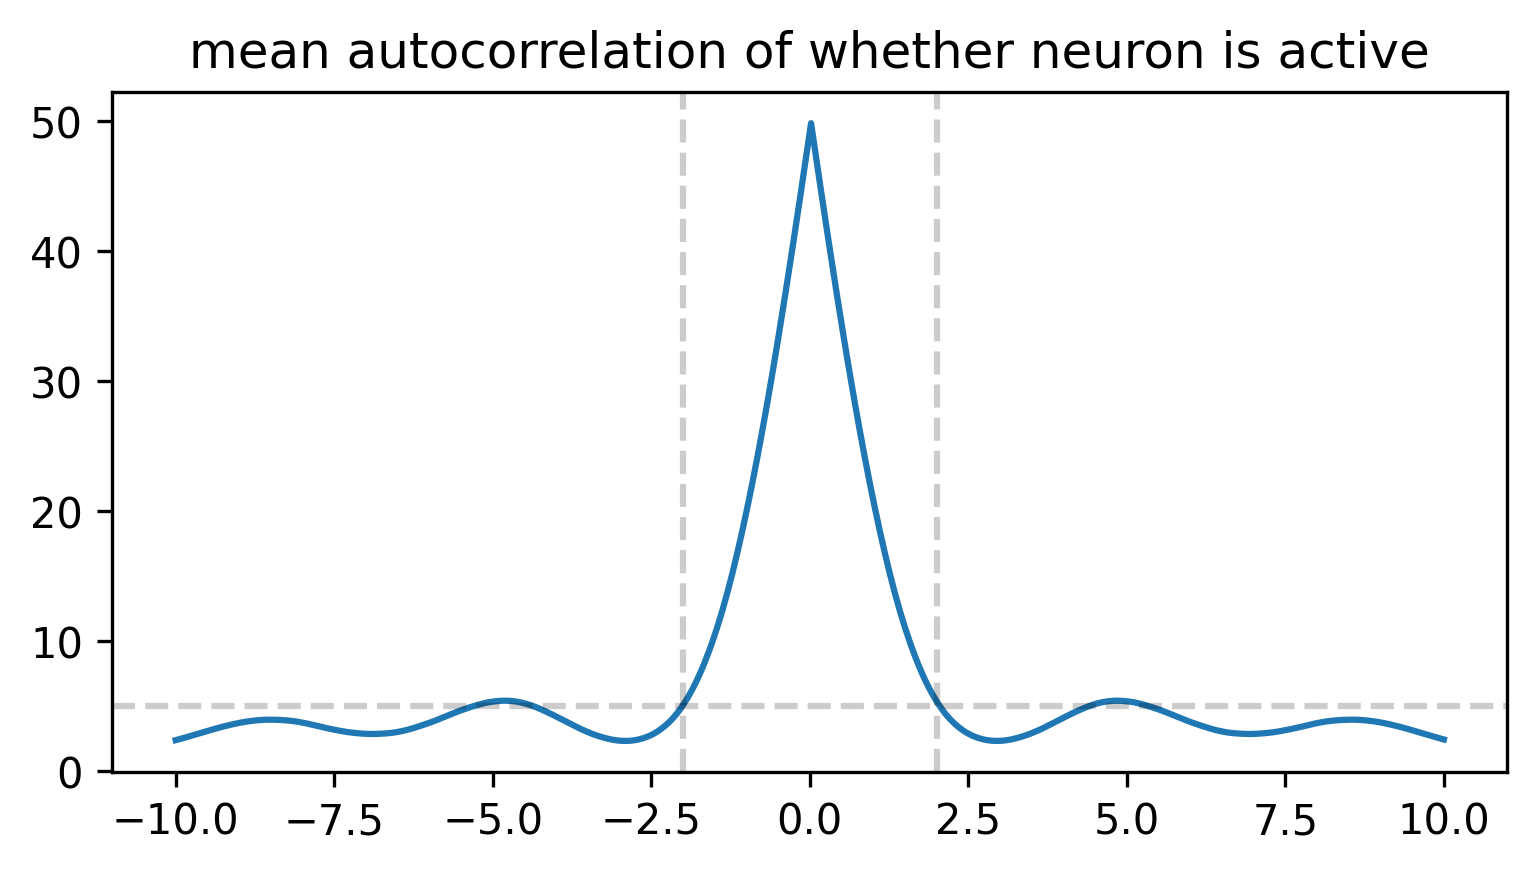

In [231]:
r = []
for a in (activity>0).astype(float).T:
    r.append(scipy.signal.correlate(a, a, 'same'))
plt.figure(figsize=(6,3), dpi=300)
plt.title('mean autocorrelation of whether neuron is active')
plt.plot(domain, np.mean(r, axis=0))
plt.axvline(-length_scale, ls='--', c='k', alpha=0.2)
plt.axvline(length_scale, ls='--', c='k', alpha=0.2)
plt.axhline(p*p*len(domain), ls='--', c='k', alpha=0.2)
plt.show()


Sweet!  The length scale is exactly the point where the autocorrelation drops to the expected background level.

## Two-dimensional SSPs

Now let's try it in 2D

In [239]:
N = 500   # number of random neurons to generate
S = 200    # number of grid steps

encoder = sspspace.RandomSSPSpace(domain_dim=2, ssp_dim=D, length_scale=length_scale)

domain_x = np.linspace(-10,10,S)  
domain_y = np.linspace(-10,10,S)  
domain = np.array(np.meshgrid(domain_x, domain_y))

domain = domain.reshape((2,-1)).T

ssp_domain = encoder.encode(domain)

# compute the bias that gives the desired sparsity
bias = sparsity_to_x_intercept(D, p=p)

# generate random SSPs for the neurons
kc_ssp = nengo.dists.UniformHypersphere(surface=True).sample(n=N, d=D)

# ReLU neuron model
def relu(x, bias):
    return np.maximum(0, x-bias)

# compute the activity
activity = relu(np.array(ssp_domain).dot(kc_ssp.T), bias=bias)


print(f'sparsity: {np.mean(activity>0)}   (desired sparsity was {p})')


sparsity: 0.0995777   (desired sparsity was 0.1)


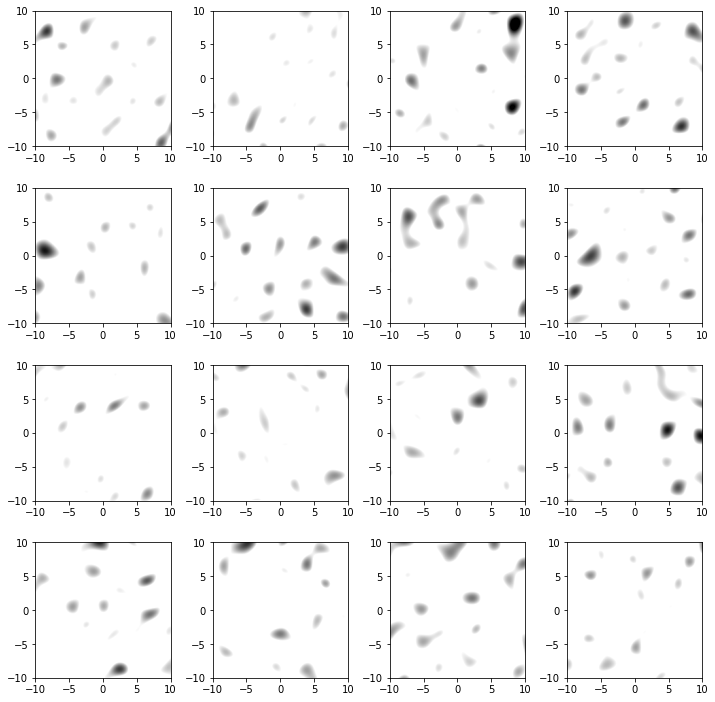

In [240]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(activity[:,i].reshape((S,S)), extent=(domain_x[0], domain_x[-1], domain_y[0], domain_y[-1]),
               vmin=0, vmax=0.1, cmap='gray_r')
plt.tight_layout()
plt.show()

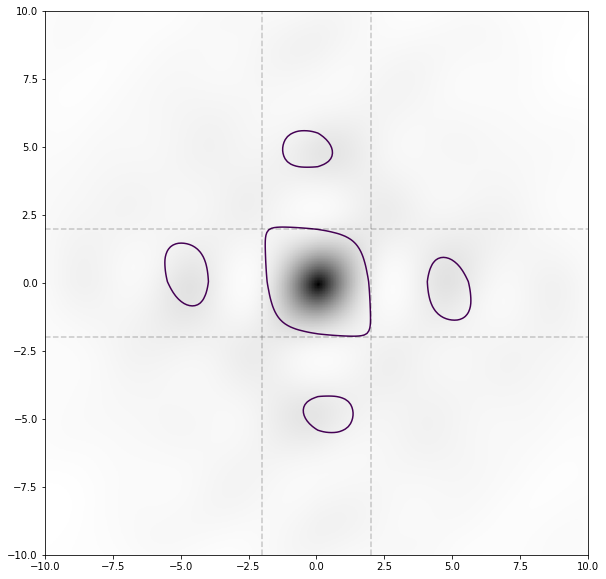

In [241]:
r = []
for a in (activity>0).astype(float).T:
    r.append(scipy.signal.correlate(a.reshape((S,S)), a.reshape((S,S)), 'same'))
rr = np.mean(r, axis=0)
plt.figure(figsize=(10,10))
plt.imshow(rr, extent=(domain_x[0], domain_x[-1], domain_y[0], domain_y[-1]), cmap='gray_r')

plt.contour(*np.meshgrid(domain_x, domain_y), rr, levels=[p*p*S*S])
plt.axvline(length_scale, ls='--', c='k', alpha=0.2)
plt.axvline(-length_scale, ls='--', c='k', alpha=0.2)
plt.axhline(length_scale, ls='--', c='k', alpha=0.2)
plt.axhline(-length_scale, ls='--', c='k', alpha=0.2)

plt.show()


This looks exactly as expected!  It's a 2D version of what was plotted for the 1D autocorrelation, and I'm using the contour line to show the horizontal slice at the expected background autocorrelation level.